In [1]:
import math
import random
import re

import pandas as pd
import matplotlib.pyplot as plt

from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution

from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm

from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.operator.crossover import PMXCrossover

from jmetal.operator import BinaryTournamentSelection
from jmetal.util.comparator import MultiComparator
from jmetal.util.ranking import StrengthRanking
from jmetal.util.density_estimator import KNearestNeighborDensityEstimator

from jmetal.util import termination_criterion
from jmetal.util.observer import ProgressBarObserver

In [2]:
# TSPLIB file reader

def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX,coordY])
        cities = pd.DataFrame(cities_coord)
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

In [3]:
# Define problem Class

class myTSP(PermutationProblem):
    def __init__(self, distance_matrix, number_of_cities):
        super(myTSP, self).__init__()
        self.distance_matrix = distance_matrix
        self.number_of_variables = number_of_cities
        self.obj_directions = [self.MINIMIZE]
        self.number_of_objectives = 1
        self.number_of_constraints = 0
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        for i in range(self.number_of_variables - 1):
            x = solution.variables[i]
            y = solution.variables[i + 1]
            fitness += self.distance_matrix[x][y]
        first_city, last_city = solution.variables[0], solution.variables[-1]
        fitness += self.distance_matrix[first_city][last_city]
        solution.objectives[0] = fitness
        fitness_log.append(fitness)
        return solution
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution

    @property
    def number_of_cities(self):
        return self.number_of_variables

    def get_name(self):
        return 'Symmetric TSP'

In [4]:
# function to make print report of function solving

def print_solution(my_algo, pop_evolved, log, params):
    algorithm_name = my_algo.get_name()
    solution_x = pop_evolved.variables
    fitness = pop_evolved.objectives[0]
    n_evals = my_algo.evaluations
    duration = my_algo.total_computing_time
    print('-' *60)
    print("Function: %s" % problem_name)
    print("Problem dimension: %d" % len(solution_x))
    print("Global Optimum: %d" % optimal_fitness)
    print('-' *60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters:")
    for p in params:
        print("\t%s: " % p ,params[p] )
    print('-' *60)
    print("Fitness: %d" % fitness)
    print("Solution: ")
    print(solution_x)
    print('-' *60)
    print("Nb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d evals" % maxevals)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log[::1000])
    plt.xlabel("evaluations (x1000)")
    plt.ylabel("fitness")
    plt.show()

In [5]:
# instantiate problem to solve

problem_name = 'Djibouti 38 TSP'
optimal_fitness = 6656
dist_matrix, nb_cities, cities_coord = read_tsplib_file('./dj38.tsp')
myproblem = myTSP(dist_matrix, nb_cities)

In [6]:
# define algorithm to use

maxevals = 200000

popsize = 400
offspring = 400
mut_prob = 0.05
cross_prob = 0.9

select = BinaryTournamentSelection(
                        MultiComparator([StrengthRanking.get_comparator(),
                                         KNearestNeighborDensityEstimator.get_comparator()]
                                       ))

termin = termination_criterion.StoppingByEvaluations(max_evaluations=maxevals)

algorithm = GeneticAlgorithm(
    problem=myproblem,
    population_size=popsize,
    offspring_population_size=offspring,
    mutation=PermutationSwapMutation(mut_prob),
    crossover=PMXCrossover(cross_prob),
    selection=select,
    termination_criterion=termin
)

params = {'population':popsize, 
          'offspring':offspring, 
          'mutation probability': mut_prob, 
          'crossover probability': cross_prob,
         }

Progress: 100%|##########| 200000/200000 [00:16<00:00, 12308.38it/s]


------------------------------------------------------------
Function: Djibouti 38 TSP
Problem dimension: 38
Global Optimum: 6656
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  400
	offspring:  400
	mutation probability:  0.05
	crossover probability:  0.9
------------------------------------------------------------
Fitness: 7739
Solution: 
[14, 12, 5, 7, 8, 11, 10, 16, 18, 17, 15, 6, 4, 2, 3, 1, 0, 9, 13, 20, 28, 34, 36, 37, 32, 33, 35, 30, 26, 27, 23, 21, 31, 29, 25, 24, 22, 19]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 16.272 seconds


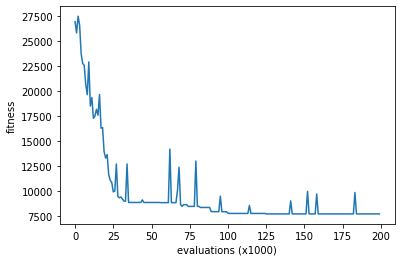

In [7]:
# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

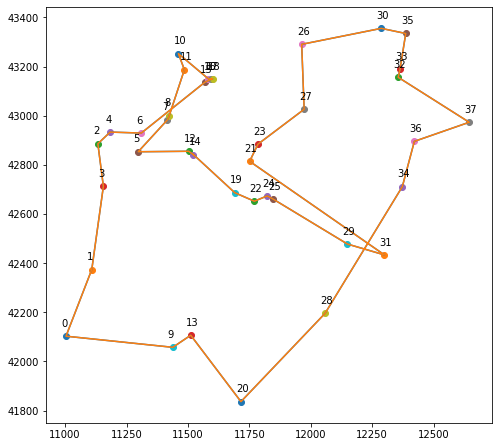

In [8]:
# display found solution

xlist = [cities_coord.iloc[i,0] for i in result.variables]
ylist = [cities_coord.iloc[i,1] for i in result.variables]

xlist.append(xlist[0])
ylist.append(ylist[0])

plt.figure(figsize=(8,8))
for idx,city in enumerate(cities_coord.values):
    plt.scatter(city[0],city[1])
    plt.text(city[0]-20, city[1]+40, str(idx), fontsize=10)

plt.plot(xlist, ylist, linestyle='-')
plt.plot(xlist, ylist, linestyle='-')
plt.axis('scaled')
plt.show()